In [1]:
import importlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

# Add parent directory to path to 
# allow imports of custom modules
if not '..' in sys.path:
    sys.path.append('..')
from utils.data.gen import get_toy_dataset
from utils.model import triplet_loss as tl

In [69]:
def _get_Rt(labels):
    """Return a 3-D mask where 
        mask[a,p,n] = 1  if l(a)==l(p) and l(a)!=l(n)
        mask[a,p,n] = -1 if l(a)!=l(p) and l(a)==l(n)
        mask[a,p,n] = 0  if l(a)==l(p) and l(a)==l(n)
                         or l(a)!=l(p) and l(a)!=l(n)
    """
    label_equal = tf.cast(
        tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1)),
        dtype=tf.float32)
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)
    
    rt_labels = tf.math.subtract(i_equal_j, i_equal_k)

    return rt_labels

In [86]:
def batch_all_triplet_loss(labels, embeddings, margin=1.0):
    
    # Get the pairwise distance matrix
    pairwise_dist = tl._pairwise_distances(embeddings, squared=True)

    # shape (batch_size, batch_size, 1)
    i_and_j = tf.expand_dims(pairwise_dist, 2)
    # shape (batch_size, 1, batch_size)
    i_and_k = tf.expand_dims(pairwise_dist, 1)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = i_and_j - i_and_k
    triplet_loss = tf.cast(triplet_loss, dtype=tf.float32)
    
    # Compute the R_t for the labels
    Rt = _get_Rt(labels)
    triplet_loss = tf.multiply(Rt, triplet_loss + margin)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive losses
    num_positive_triplets = tf.reduce_sum(
        tf.cast(tf.greater(triplet_loss, 1e-16), tf.float32))
        
    # Get final mean triplet loss over all triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss

## Example with perfectly seperated embeddings

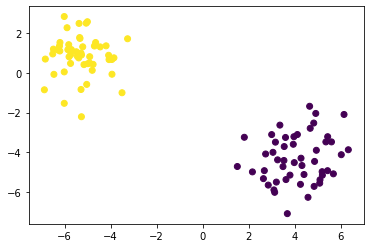

In [79]:
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=2, random_state=123)
plt.scatter(X[:,0], X[:,1], c=y)

In [80]:
X = tf.convert_to_tensor(X, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

In [83]:
batch_all_triplet_loss(y, X).numpy()

0.0

## Example with non-linearly seperated (i.e. bad) embeddings

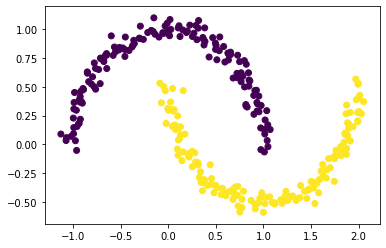

In [84]:
X, y = get_toy_dataset('moons', n_samples=300, seed=30)
plt.scatter(X[:,0], X[:,1], c=y)

In [85]:
batch_all_triplet_loss(y, X).numpy()

1.3950695